In [1]:
from copy import deepcopy
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

### Load datasets

In [2]:
train = pd.read_csv('datasets/train_imputed.csv')
test = pd.read_csv('datasets/test_imputed.csv')

#### Feature Engineering

##### Add day and month

In [3]:
# Add day and month columns
train['date_time'] = pd.to_datetime(train['date_time'])
train['month'] = train['date_time'].dt.month
train['day'] = train['date_time'].dt.day

test['date_time'] = pd.to_datetime(test['date_time'])
test['month'] = test['date_time'].dt.month
test['day'] = test['date_time'].dt.day

# Drop date time column
train.drop(['date_time'], axis=1, inplace=True)
test.drop(['date_time'], axis=1, inplace=True)

Normalized Price

In [4]:
# Version 1
train["price_usd_normalized1"] = train["price_usd"] / train["srch_length_of_stay"]
test["price_usd_normalized1"] = test["price_usd"] / test["srch_length_of_stay"]
# Version 2
train["price_usd_normalized2"] = train["price_usd"] / (train["srch_length_of_stay"] * train["srch_adults_count"])
test["price_usd_normalized2"] = test["price_usd"] / (test["srch_length_of_stay"] * test["srch_adults_count"])
# Version 3
train["price_usd_normalized3"] = train["price_usd"] / (train["srch_length_of_stay"] * (train["srch_adults_count"] + train["srch_children_count"]))
test["price_usd_normalized3"] = test["price_usd"] / (test["srch_length_of_stay"] * (test["srch_adults_count"] + test["srch_children_count"]))

##### Cols selection / Separate Categorical 

In [5]:
# ---- Get types of columns
# Deze klopt niet, het zijn er meer --> ook bools voor missing values/ niet boeiend voor feature creatie, maar niet verwijderen!!!!
categorical_columns = ["random_bool", "srch_saturday_night_bool", "srch_destination_id", "promotion_flag", "srch_id", "site_id", "visitor_location_country_id", "prop_country_id", "prop_id", "prop_review_score", "prop_brand_bool",
                       'month', 'day']
# Numerical
numerical_columns = ["orig_destination_distance", "srch_query_affinity_score", "srch_room_count", "srch_children_count", "srch_adults_count", "srch_booking_window", "srch_length_of_stay", "diff starrating", "diff hotel price", "prop_location_score1", "prop_location_score2",
                     "price_usd", "prop_log_historical_price", "price_usd_normalized1", "price_usd_normalized2", "price_usd_normalized3"]
# Target
target_columns = ['click_bool', 'booking_bool', 'position', 'gross_bookings_usd']

##### Normalisation

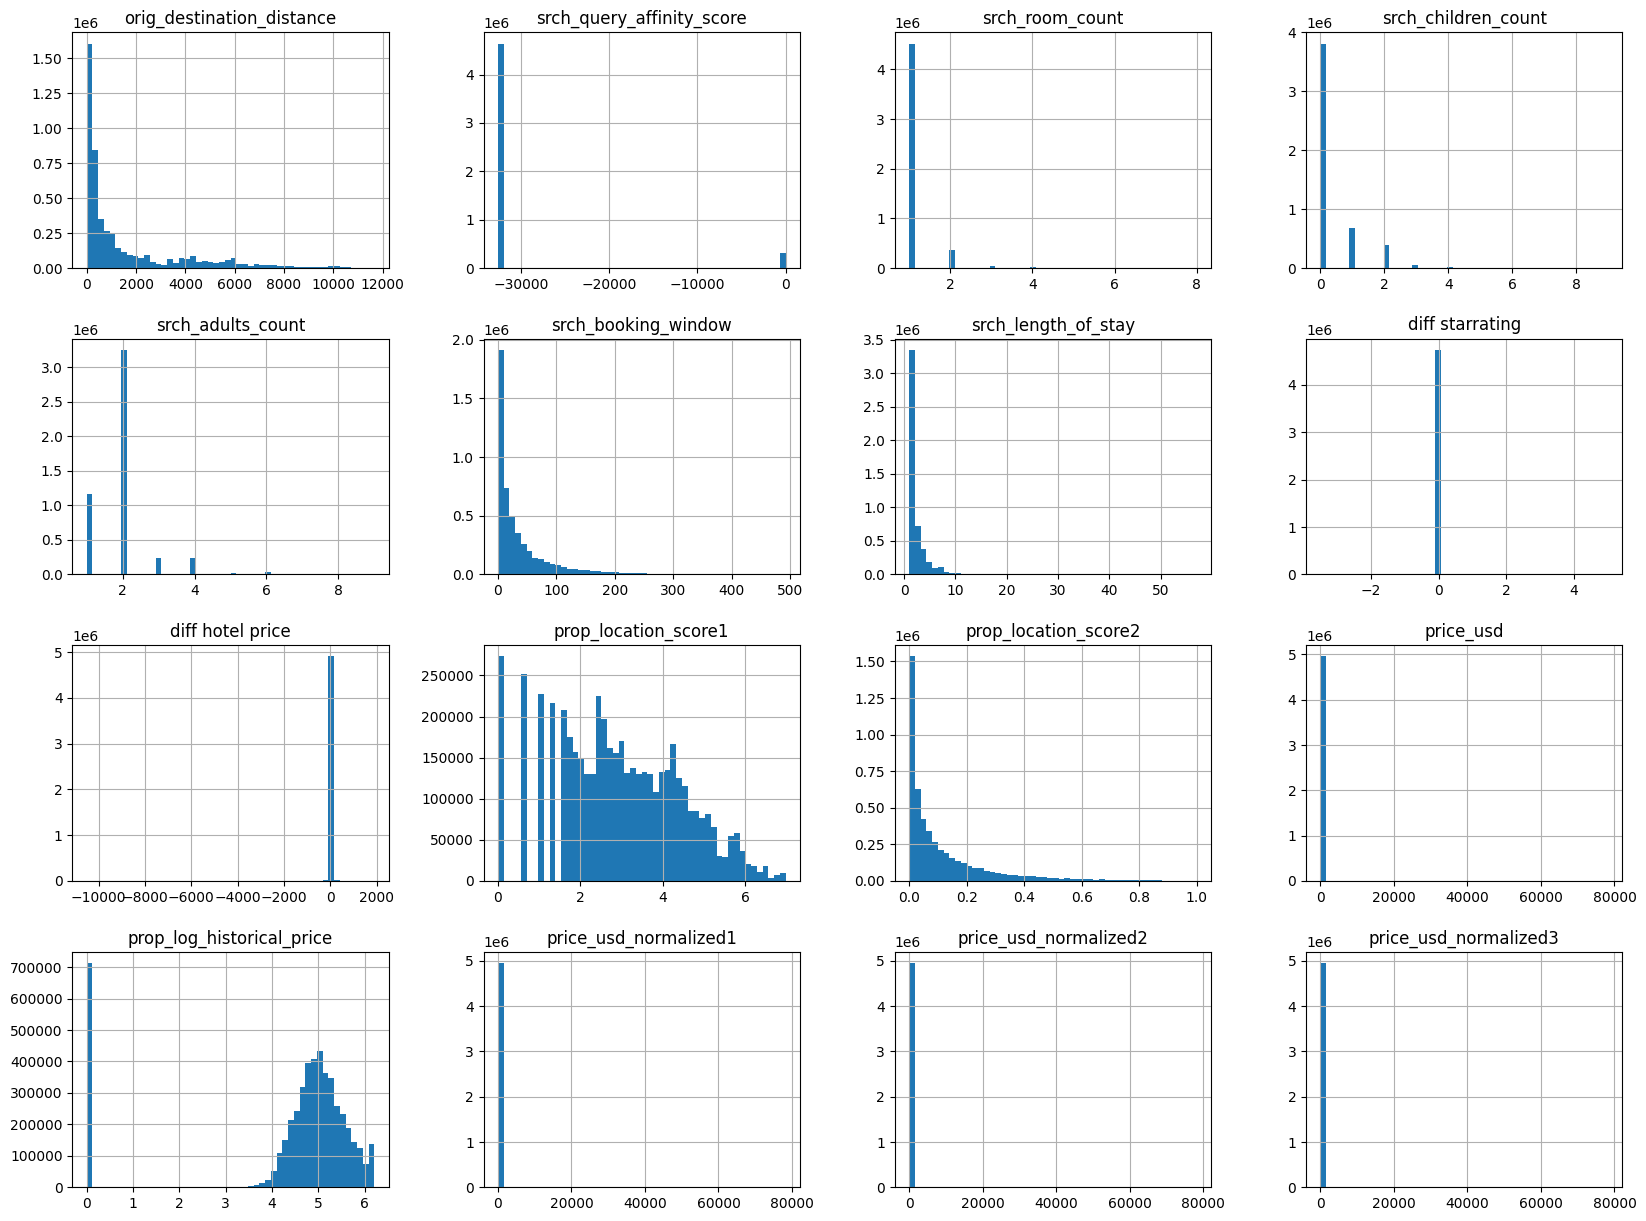

In [6]:
# Get distribution grid of numerical columns
train[numerical_columns].hist(bins=50, figsize=(20,15))
plt.show()

In [7]:
dfcombined = pd.concat([train, test], ignore_index = True)
del train
del test

#### Normalize (Should be very picky because of memory errors)

In [8]:
# ---- Log normalize by variables
cols2normalize = ["price_usd", "prop_location_score1", "prop_location_score2", "orig_destination_distance", 
                "srch_query_affinity_score", "diff starrating", "diff hotel price", "prop_log_historical_price",
                "price_usd_normalized1", "price_usd_normalized2", "price_usd_normalized3"]


for group in ['srch_id']: #, 'visitor_location_country_id', "month", "srch_destination_id", 'prop_country_id', 'prop_id', "srch_destination_id", "srch_length_of_stay", "srch_booking_window"]:
    print(group)
    cols2cons = [col for col in cols2normalize if col != group]
    new_cols = [col + "_normalized_by_" + group for col in cols2cons]
    dfcombined.loc[:, new_cols] = dfcombined.groupby(group)[cols2cons].transform((lambda x: (x - x.median()) / x.std()))

srch_id


##### Impute median of target value per group

In [11]:
for col in ["srch_destination_id", "srch_id", "site_id", "visitor_location_country_id", "prop_country_id", "prop_id", "prop_review_score", "prop_brand_bool", 'month', 'day']:
    grouped = dfcombined.groupby(col)["position"]
    n = grouped.transform('count')
    mean = grouped.transform('mean')
    dfcombined["mean_position_" + col] = (mean*n - dfcombined['position'])/(n-1)

#### Aggregate competitor values

In [14]:
# Sum competitor --> The null values should actually be -1, but then we need to save the bool first!!! --> To do!!!!
dfcombined.loc[:, "aggr_comp"] = dfcombined["comp1_rate"] + 1

# Impute with zero
for icomp in range(2, 9):
    # Get  column name
    col1 = "comp" + str(icomp) + "_rate"
    # Add
    dfcombined.loc[:, "aggr_comp"] = dfcombined["aggr_comp"] + (dfcombined[col] + 1)
    dfcombined.loc[:, "aggr_comp"] = dfcombined["aggr_comp"] + (dfcombined[col] + 1)

#### Convert target column?

In [15]:
# --- Add target column to train_df, 0 if click_bool = 0 and 5 if booking_bool = 1, else 1
dfcombined.loc[:, 'target'] = np.where(dfcombined.loc[:, 'booking_bool'] == 1, 5, np.where(dfcombined.loc[:, 'click_bool'] == 1, 1, 0))
#train_df.drop(['click_bool', 'booking_bool'], axis=1, inplace=True)

In [31]:
#dfcombined = dfcombined.drop(target_columns, axis=1)
dfcombined.to_csv("combined_features.csv")

#### Hyper-parameter tuning

#### Training

In [20]:
import xgboost as xgb
import optuna.integration.lightgbm as lgb
from sklearn.model_selection import train_test_split

In [21]:
params = {
        'objective': 'lambdarank',
        'boosting_type': 'gbdt',
        'metric': 'ndcg',
        'learning_rate': 0.06,
        'num_leaves': 50,
        'max_depth': 15,
        'num_iterations': 500,
    }

In [29]:
lambdamart = lgb.LightGBMRanker(**params)

AttributeError: module 'optuna.integration.lightgbm' has no attribute 'LightGBMRanker'

In [ ]:
def objective(trial): 
    param = {
        "objective": "lambdarank",
        "metric": "ndcg",
        "verbosity": -1,
        "boosting_type": "gbdt",                
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 15),
    }
    lambdamart = lgb.LGBMRanker(**param)


    lambdamart.fit(X_train, y_train, group=group, eval_set=[(X_val, y_val)], eval_group=[val_groups], eval_at=[5], early_stopping_rounds=10, verbose=10)


X = train_df.drop(['target'], axis=1)
y = train_df['target']
search_ids = X['srch_id'].unique()
group_dict = {id_: i for i, id_ in enumerate(search_ids)}
groups = [group_dict[id_] for id_ in X['srch_id']]
groups = np.array(groups)

In [11]:
from sklearn.model_selection import GroupKFold
X = train_df.drop(['target'], axis=1)
y = train_df['target']

n_folds = 5
gkf = GroupKFold(n_splits=n_folds)

# Get the search ID column and create a dictionary that maps each unique ID to a unique group ID
search_ids = X['srch_id'].unique()
group_dict = {id_: i for i, id_ in enumerate(search_ids)}

# Use the dictionary to create a list of group IDs for each row in the dataset
groups = [group_dict[id_] for id_ in X['srch_id']]
groups = np.array(groups)

for fold, (train_index, val_index) in enumerate(gkf.split(X, y, groups)):
    print(f'Fold: {fold + 1}')
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    group = X_train.groupby('srch_id').size().to_numpy()
    val_groups = X_val.groupby('srch_id').size().to_numpy()


    lambdamart.fit(X_train, y_train, group=group, eval_set=[(X_val, y_val)], eval_group=[val_groups], eval_at=[5], early_stopping_rounds=10, verbose=10)
    print('')

Fold: 1


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 10 rounds.
[10]	valid_0's ndcg@5: 0.331951
[20]	valid_0's ndcg@5: 0.340972
[30]	valid_0's ndcg@5: 0.34638
[40]	valid_0's ndcg@5: 0.350593
[50]	valid_0's ndcg@5: 0.354357
[60]	valid_0's ndcg@5: 0.356797
[70]	valid_0's ndcg@5: 0.359321
[80]	valid_0's ndcg@5: 0.361318
[90]	valid_0's ndcg@5: 0.363134
[100]	valid_0's ndcg@5: 0.364539
[110]	valid_0's ndcg@5: 0.365828
[120]	valid_0's ndcg@5: 0.367189
[130]	valid_0's ndcg@5: 0.368135
[140]	valid_0's ndcg@5: 0.369196
[150]	valid_0's ndcg@5: 0.369993
[160]	valid_0's ndcg@5: 0.370908
[170]	valid_0's ndcg@5: 0.371766
[180]	valid_0's ndcg@5: 0.372403
[190]	valid_0's ndcg@5: 0.372694
[200]	valid_0's ndcg@5: 0.373037
[210]	valid_0's ndcg@5: 0.373363
[220]	valid_0's ndcg@5: 0.373972
[230]	valid_0's ndcg@5: 0.374321
[240]	valid_0's ndcg@5: 0.375034
[250]	valid_0's ndcg@5: 0.375479
[260]	valid_0's ndcg@5: 0.375779
[270]	valid_0's ndcg@5: 0.376032
[280]	valid_0's ndcg@5: 0.3766
[290]	valid_0's ndcg@5: 0.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

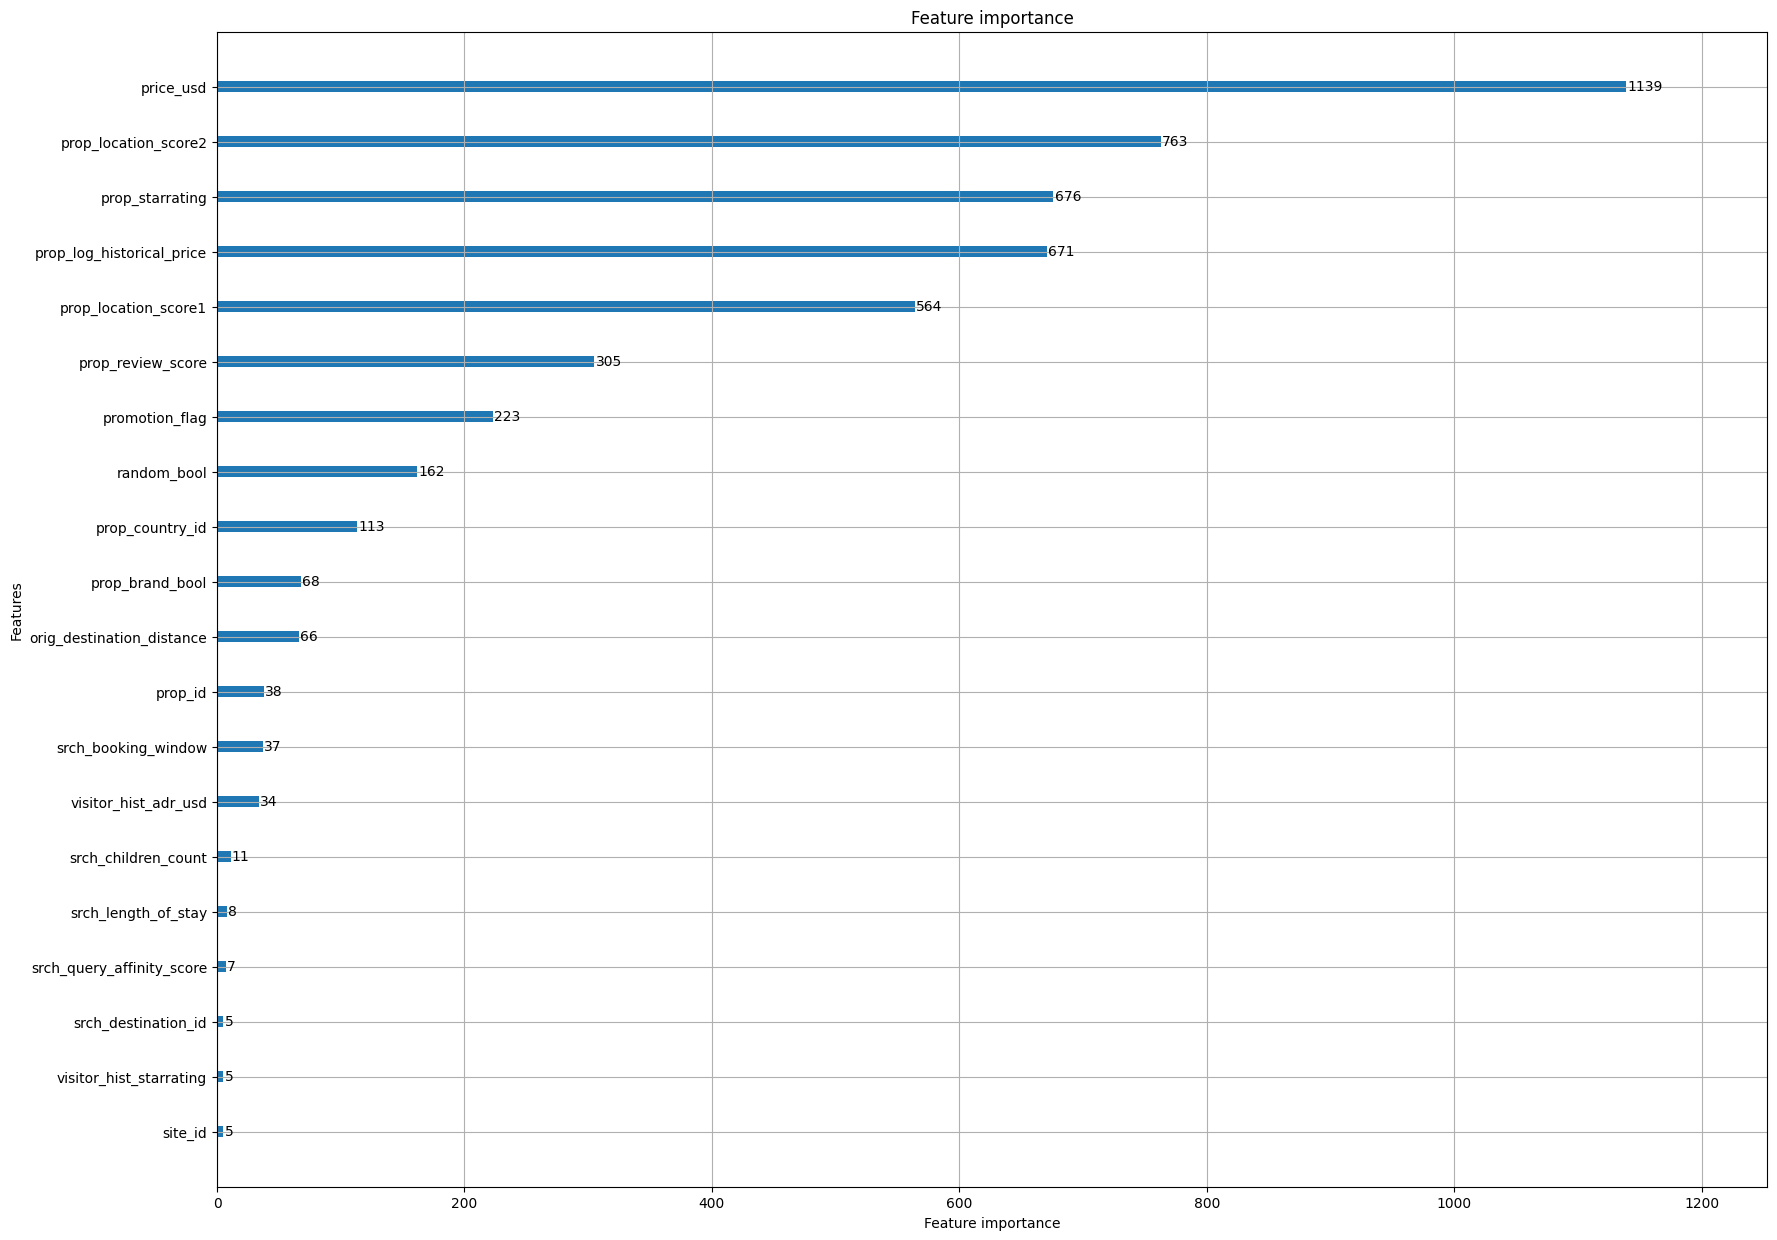

In [15]:
lgb.plot_importance(lambdamart, figsize=(20,15))


In [ ]:
#Get ranking per srch_id based on pred column. Only display srch_id and prop_id
#ranking = train_df.sort_values(['srch_id', 'pred'], ascending=[True, False]).loc[:, ['srch_id', 'prop_id', 'target']]

In [16]:
#Which columns does test_df have and train_df not?
cols = set(test_df.columns) - set(train_df.columns)

In [18]:
test_df.drop(cols, axis=1, inplace=True)

In [19]:
#group test data by srch_id
grouped_test = test_df.groupby('srch_id')

#per grouped search predict the ranking
preds = []
for name, group in grouped_test:
    prediction = lambdamart.predict(group)
    preds.append(prediction)

In [21]:
preds = np.concatenate(preds)

In [23]:
#add predictions to test_df
test_df['pred'] = preds

In [24]:
#Get ranking per srch_id based on pred column. Only display srch_id and prop_id
ranking = test_df.sort_values(['srch_id', 'pred'], ascending=[True, False]).loc[:, ['srch_id', 'prop_id']]

In [25]:
ranking.to_csv('datasets/ranking.csv', index=False)